In [ ]:
import cv2
from matplotlib import pyplot as plt
from skimage import io
import skimage
import numpy as np
from scipy.signal import convolve2d, correlate2d,gaussian
from skimage.feature import peak_local_max
%matplotlib inline

In [ ]:
def create_gaussian_filter(ksize, sigma):
    #This function creates gaussian filter for an arbitary size

    assert ksize%2 !=0  # assert that the length is odd

    x = gaussian(M=ksize, std=sigma)
    y = gaussian(M=ksize, std=sigma)
    x_1,y_1 = np.meshgrid(x,y)
    gauss_kernel = x_1*y_1
    gauss_kernel = gauss_kernel/gauss_kernel.sum()
    
    return gauss_kernel

In [ ]:
def Harris_detector(img_path):
    ''' This funtion takes image path and return the cornerness response of the image
        ----------------
        parametrs
        img_path: path to image
        ----------------
        returns
        R: cornerness response (2d matrix same shape as the gray scale image)
    '''
    #image import
    image = cv2.imread(img_path)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img = skimage.img_as_float32(img)
    
    # gradient filters
    sobelx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobely= np.array([[1,2,1],[0,0,0],[-1,-2,-1]])


    #getting direvatives of gaussian 
    gaussian_filter = create_gaussian_filter(5,1)
    Gx = convolve2d(gaussian_filter,sobelx,'same')
    Gy = convolve2d(gaussian_filter,sobely,'same')

    #convolving the drevatives of gaussian with the image
    Ix = convolve2d(img,Gx,'same')
    Iy = convolve2d(img,Gy,'same')
    
    #different way to get the Ix and Iy
    #Ig = convolve2d(img,gaussian_filter,'same')
    #Ix = convolve2d(Ig,sobelx,'same')
    #Iy = convolve2d(Ig,sobely,'same')

    Ix_Ix = np.multiply(Ix,Ix)
    Iy_Iy = np.multiply(Iy,Iy)
    Ix_Iy =np.multiply(Ix,Iy)



    alpha = 0.04

    ##implementation using for loop --- the following implemenation is getting the sum and R using for loop. with 2 different 
    ##                                  windows options avaiable, rect window and gaussian weights window. while using the 
    ##                                  gaussian weights window. multiplying with gaussian kernel then taking taking the 
    ##                                  sum is the same as convolotion or correlation. So, ready made convolution is used to
    ##                                  speed up the code. The result of the for loop and convolotion is the same anyway. 
    ##                              --- to use the for loop insted of the convolution, you can comment the section
    ##                                  between #* and uncomment the section between #**

    #for loop implementation 
    #*
    #height,width = Ix_Ix.shape
    #Sx = np.zeros((height,width))
    #Sy = np.zeros((height,width))
    #Sxy = np.zeros((height,width))
    #R = np.zeros((height,width))
    #for row in range(2,height - 4):
    #    for col in range(2,width - 4):
    #        #sum with gaussian window
    #        Sx[row,col] = np.sum(np.multiply(Ix_Ix[row-2:row+3,col-2:col+3],gaussian_filter))
    #        Sy[row,col] = np.sum(np.multiply(Iy_Iy[row-2:row+3,col-2:col+3],gaussian_filter))
    #        Sxy[row,col] = np.sum(np.multiply(Ix_Iy[row-2:row+3,col-2:col+3],gaussian_filter))
    #        #uncomment the 3 following lines and comment the 3 previous for using rect window instead of gaussian
    #        #Sx[row,col] = np.sum(Ix_Ix[row-2:row+3,col-2:col+3])
    #        #Sy[row,col] = np.sum(Iy_Iy[row-2:row+3,col-2:col+3])
    #        #Sxy[row,col] = np.sum(Ix_Iy[row-2:row+3,col-2:col+3])
    #
    #        R[row,col] = (Sx[row,col]*Sy[row,col] - Sxy[row,col]*Sxy[row,col]) - alpha*(Sx[row,col]+Sy[row,col])**2

    #*

    #convolution implementation 
    #**
    gaussian_weights = create_gaussian_filter(3,1)
    Sx = convolve2d(Ix_Ix,gaussian_weights,'same')
    Sy = convolve2d(Iy_Iy,gaussian_weights,'same')
    Sxy = convolve2d(Ix_Iy,gaussian_weights,'same')
    R = (Sx*Sy - Sxy*Sxy) - alpha*(Sx+Sy)**2
    #**
    return R

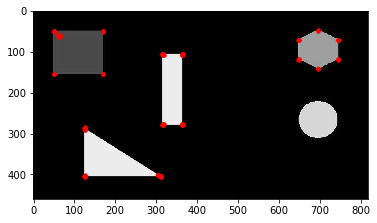

In [ ]:
#image import to plot
image_path = 'assets/corners.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = skimage.img_as_float32(gray)

#getting the cornerness response
R = Harris_detector(image_path)

#thresholding
threshold = np.max(R)*0.001 #different threshold values detect different number of corners        
ret, thresholded_image = cv2.threshold(R, threshold, 1.0, 0)
plt.imshow(gray,cmap='gray')

#get local max 
coordinates = peak_local_max(thresholded_image, min_distance=20)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')